In [1]:
# Load labelled clinical

from pathlib import Path
import pandas as pd

PROJECT = Path.cwd()
PROCESSED = PROJECT / "data" / "processed"

clin = pd.read_csv(PROCESSED / "clinical_with_subtypes_k2.csv", index_col=0)
print("clin:", clin.shape)
print(clin["subtype"].value_counts())



clin: (95, 131)
subtype
C1    54
C2    41
Name: count, dtype: int64


In [2]:
# Extract OS time + event (clean numeric)

time_col = "Overall survival, days"
event_col = "Survival status (1, dead; 0, alive)"

df = clin[["subtype", time_col, event_col]].copy()
df["time"] = pd.to_numeric(df[time_col], errors="coerce")
df["event"] = pd.to_numeric(df[event_col], errors="coerce")

# keep only rows with both time + event
df = df.dropna(subset=["time", "event"])

# event must be 0/1
df["event"] = df["event"].astype(int)

print("usable rows:", df.shape[0])
print(df.groupby("subtype")[["time","event"]].agg({"time":["count","median"], "event":"sum"}))


usable rows: 95
         time         event
        count  median   sum
subtype                    
C1         54  1076.5     7
C2         41   775.0     3


In [ ]:
!python -m pip install lifelines


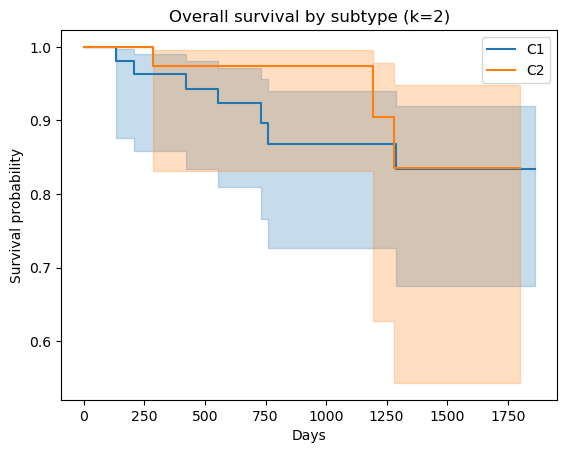

In [5]:
# Kaplan–Meier plot

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure()

for grp in sorted(df["subtype"].unique()):
    mask = df["subtype"] == grp
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df.loc[mask, "time"], event_observed=df.loc[mask, "event"], label=grp)
    kmf.plot_survival_function()

plt.title("Overall survival by subtype (k=2)")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.show()



In [7]:
# Log-rank test (p-value)

from lifelines.statistics import logrank_test

groups = sorted(df["subtype"].unique())
g1, g2 = groups[0], groups[1]

d1 = df[df["subtype"] == g1]
d2 = df[df["subtype"] == g2]

res = logrank_test(d1["time"], d2["time"], event_observed_A=d1["event"], event_observed_B=d2["event"])
print("Log-rank p-value:", res.p_value)


Log-rank p-value: 0.5246360085331305
